In [1]:
import numpy as np
import matplotlib.pyplot as plt

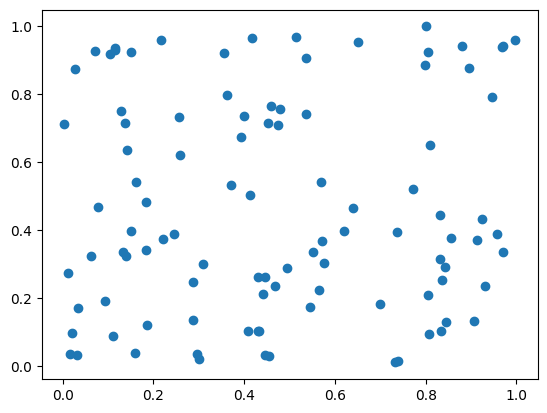

In [2]:
n = 100
d = 2
X = np.random.rand(n,d)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [3]:
import scipy as sp
import scipy.spatial
import scipy.spatial.distance as distance

In [4]:
def knn(x, X, k, **kwargs):
    """
    find indices of k-nearest neighbors of x in X
    """
    d = distance.cdist(x.reshape(1,-1), X, **kwargs).flatten()
    return np.argpartition(d, k)[:k]

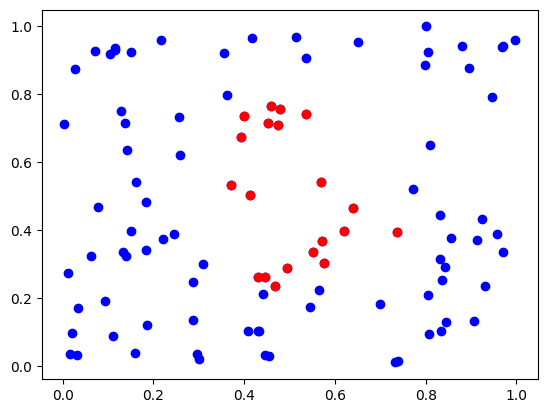

In [5]:
x = np.array([[0.5,0.5]])

inds = knn(x, X, 20)
plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

In [6]:
class KDTree(object):
    
    """
    This implementation only supports Euclidean distance. 
    The points can be any array-like type, e.g: 
        lists, tuples, numpy arrays.
    Usage:
    1. Make the KD-Tree:
        `kd_tree = KDTree(points, dim)`
    2. You can then use `get_knn` for k nearest neighbors or 
       `get_nearest` for the nearest neighbor
    points are given in a list of points: [[0, 1, 2], [12.3, 4.5, 2.3], ...]
    """
    def __init__(self, points, dim, dist_sq_func=None):
        """Makes the KD-Tree for fast lookup.
        Parameters
        ----------
        points : list<point>
            A list of points.
        dim : int 
            The dimension of the points. 
        dist_sq_func : function(point, point), optional
            A function that returns the squared Euclidean distance
            between the two points. 
            If omitted, it uses the default implementation.
        """

        if dist_sq_func is None:
            dist_sq_func = lambda a, b: sum((x - b[i]) ** 2 
                for i, x in enumerate(a))
                
        def make(points, i=0):
            if len(points) > 1:
                try:
                    points.sort(key=lambda x: x[i]) # list|tuple
                except TypeError:
                    points.sort(axis=i) # np.ndarray
                #points.sort(key=lambda x: x[i])
                i = (i + 1) % dim
                m = len(points) >> 1 # same as len(points) // 2 but with bitewise operation
                return [make(points[:m], i), make(points[m + 1:], i), 
                    points[m]]
            if len(points) == 1:
                return [None, None, points[0]]
        
        def add_point(node, point, i=0):
            if node is not None:
                dx = node[2][i] - point[i]
                for j, c in ((0, dx >= 0), (1, dx < 0)):
                    if c and node[j] is None:
                        node[j] = [None, None, point]
                    elif c:
                        add_point(node[j], point, (i + 1) % dim)

        import heapq
        def get_knn(node, point, k, return_dist_sq, heap, i=0, tiebreaker=1):
            if node is not None:
                dist_sq = dist_sq_func(point, node[2])
                dx = node[2][i] - point[i]
                if len(heap) < k:
                    heapq.heappush(heap, (-dist_sq, tiebreaker, node[2]))
                elif dist_sq < -heap[0][0]:
                    heapq.heappushpop(heap, (-dist_sq, tiebreaker, node[2]))
                i = (i + 1) % dim
                # Goes into the left branch, then the right branch if needed
                for b in (dx < 0, dx >= 0)[:1 + (dx * dx < -heap[0][0])]:
                    get_knn(node[int(b)], point, k, return_dist_sq, 
                        heap, i, (tiebreaker << 1) | b)
            if tiebreaker == 1:
                return [(-h[0], h[2]) if return_dist_sq else h[2] 
                    for h in sorted(heap)][::-1]

        self._add_point = add_point
        self._get_knn = get_knn 
        self._root = make(points)

    def __iter__(self):
        return self._walk(self._root)
        
    def add_point(self, point):
        """Adds a point to the kd-tree.
        
        Parameters
        ----------
        point : array-like
            The point.
        """
        if self._root is None:
            self._root = [None, None, point]
        else:
            self._add_point(self._root, point)

    def get_knn(self, point, k, return_dist_sq=True):
        """Returns k nearest neighbors.
        Parameters
        ----------
        point : array-like
            The point.
        k: int 
            The number of nearest neighbors.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distances.
        Returns
        -------
        list<array-like>
            The nearest neighbors. 
            If `return_dist_sq` is true, the return will be:
                [(dist_sq, point), ...]
            else:
                [point, ...]
        """
        return self._get_knn(self._root, point, k, return_dist_sq, [])

    def get_nearest(self, point, return_dist_sq=True):
        """Returns the nearest neighbor.
        Parameters
        ----------
        point : array-like
            The point.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distance.
        Returns
        -------
        array-like
            The nearest neighbor. 
            If the tree is empty, returns `None`.
            If `return_dist_sq` is true, the return will be:
                (dist_sq, point)
            else:
                point
        """
        l = self._get_knn(self._root, point, 1, return_dist_sq, [])
        return l[0] if len(l) else None


In [7]:
kd_tree = KDTree(list(X), 2)

In [8]:
list_knn = kd_tree.get_knn([0.5,0.5], 20)

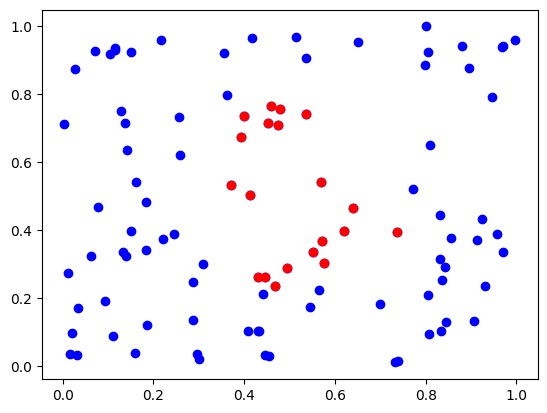

In [9]:
plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter([point[0] for (_,point) in list_knn], [point[1] for (_,point) in list_knn] , c='r')
plt.show()

In [10]:
# line width for visualization of K-D tree
LINE_WIDTH = [4., 3.5, 3., 2.5, 2., 1.5, 1., .5, .3]
DELTA = 0.1

def plot_tree(root, n_iter=None):
    def _plot_node(node):
        if not node:
            return
        plt.plot(node[2][0], node[2][1], 'ko')
        _plot_node(node[0])
        _plot_node(node[1])
        
    def _plot(node, range_x, range_y, n_iter, depth=0):
        if not(n_iter is None):
            n_iter -= 1
        if not node:
            return
        line_width = LINE_WIDTH[-1]
        if depth < len(LINE_WIDTH):
            line_width = LINE_WIDTH[depth]
        if (n_iter is None) or (n_iter>=0):
            axis = depth % len(node[2])
            if axis == 0:
                plt.plot([node[2][0], node[2][0]], [range_y[0], range_y[1]],
                         linestyle='-', color='red', linewidth=line_width)
                _plot(node[0], (range_x[0], node[2][0]), range_y, n_iter, depth + 1)
                _plot(node[1], (node[2][0], range_x[1]), range_y, n_iter, depth + 1)
            else:
                plt.plot([range_x[0], range_x[1]], [node[2][1], node[2][1]],
                         linestyle='-', color='blue', linewidth=line_width)
                _plot(node[0], range_x, (range_y[0], node[2][1]), n_iter, depth + 1)
                _plot(node[1], range_x, (node[2][1], range_y[1]), n_iter, depth + 1)
 
            plt.plot(node[2][0], node[2][1], 'ko')
        else:
            _plot_node(node)
 
    min_ = 0 - DELTA
    max_ = 1 + DELTA
    _plot(root, (min_, max_), (min_, max_), n_iter)

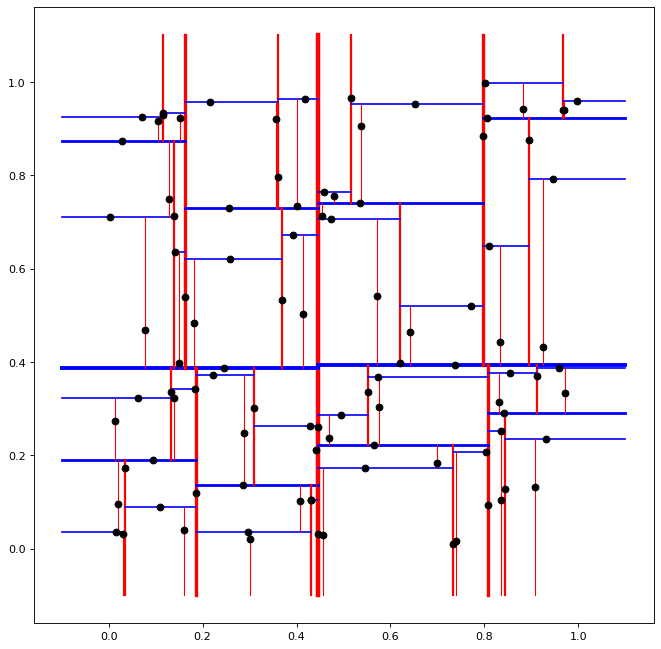

In [11]:
fig = plt.figure(figsize=(10, 10), dpi=80)
plot_tree(kd_tree._root)

In [12]:
from PIL import Image

img=Image.open("joconde.png")

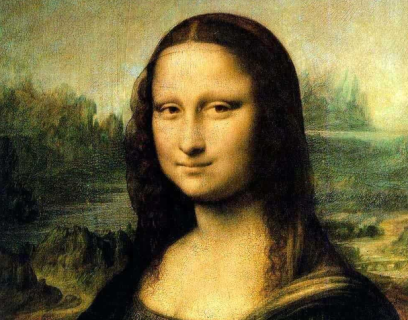

In [13]:
img

In [14]:
largeur,hauteur=img.size

In [15]:
def get_mask(w,h,p):
    return np.random.choice(a=[False, True], size=(w, h), p=[p, 1-p])

In [16]:
def generate_points(mask):
    (w,h) = mask.shape
    noise_points = []
    color_points = []
    for x in range(w):
        for y in range(h):
            if mask[x,y]:
                color_points.append((x,y))
            else:
                noise_points.append((x,y))
    return color_points, noise_points

In [17]:
mask = get_mask(largeur, hauteur, 0.7)

In [18]:
color_points, noise_points = generate_points(mask)

In [19]:
img2=Image.new('RGB',(largeur,hauteur))

In [20]:
for p in color_points:
    r,v,b,a=img.getpixel((p[0],p[1]))
    img2.putpixel((p[0],p[1]),(r,v,b))

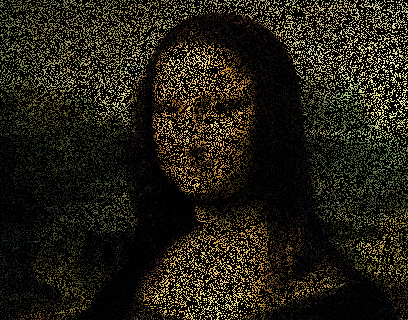

In [21]:
img2

In [22]:
kd_tree_j = KDTree(color_points, 2)

In [23]:
import copy

def restore(img, k, kd_tree, noise_points):
    restore_image = copy.deepcopy(img)
    for p in noise_points:
        knn_p = kd_tree.get_knn(p, k, return_dist_sq=False)
        r_m = []
        v_m = []
        b_m = []
        for np in knn_p:
            r,v,b = img2.getpixel((np[0],np[1]))
            r_m.append(r)
            v_m.append(v)
            b_m.append(b)
        r_m = int(sum(r_m)/k)
        v_m = int(sum(v_m)/k)
        b_m = int(sum(b_m)/k)
        restore_image.putpixel((p[0],p[1]),(r_m,v_m,b_m))
    return restore_image

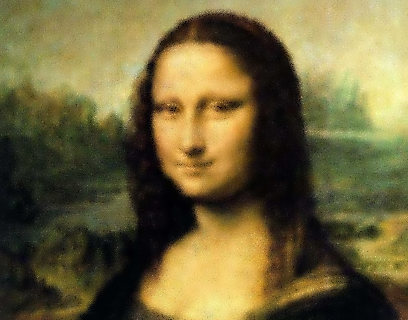

In [24]:
restored_image_20 = restore(img2,20,kd_tree_j,noise_points)
restored_image_20